# Brain Tumor Dataset
##### Dataset used: https://figshare.com/articles/brain_tumor_dataset/1512427/5

This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images
from 233 patients with three kinds of brain tumor: meningioma (708 slices), 
glioma (1426 slices), and pituitary tumor (930 slices). Due to the file size
limit of repository, we split the whole dataset into 4 subsets, and achive 
them in 4 .zip files with each .zip file containing 766 slices.The 5-fold
cross-validation indices are also provided.

-----
This data is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

    cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
    cjdata.PID: patient ID
    cjdata.image: image data
    cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.
    cjdata.tumorMask: a binary image with 1s indicating tumor region

-----
This data was used in the following paper:
1. Cheng, Jun, et al. "Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation
and Partition." PloS one 10.10 (2015).
2. Cheng, Jun, et al. "Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector 
Representation." PloS one 11.6 (2016). Matlab source codes are available on github 
https://github.com/chengjun583/brainTumorRetrieval

-----
Jun Cheng
School of Biomedical Engineering
Southern Medical University, Guangzhou, China
Email: chengjun583@qq.com

### 0. Eliminar una carpeta 

### 1. Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Installs and Imports

In [ ]:
!pip install -q hdf5storage

import os
import sys
import cv2
import numpy as np
import pandas as pd

import hdf5storage

import matplotlib.pyplot as plt
from matplotlib import cm



from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.svm import SVC
from sklearn.cluster import KMeans

import time
import progressbar

from mpl_toolkits.mplot3d import Axes3D

     |████████████████████████████████| 53 kB 1.5 MB/s 


In [ ]:
%cd /content/drive/MyDrive/Deep_Learning_Project_DATASET

# create a directory
%mkdir brain_tumor_dataset
%cd brain_tumor_dataset

# download the dataset
!wget https://ndownloader.figshare.com/articles/1512427/versions/5

# unzip the dataset and delete the zip
!unzip 5 && rm 5

# concatenate the multiple zipped data in a single zip
%cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip

# remove the temporary files
%rm brainTumorDataPublic_*

# unzip the full archive and delete it 
!unzip data.zip -d data && rm data.zip

# check that "data" contains 3064 files
%ls data | wc -l

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 copying: 2372.mat  (264868 bytes)
 copying: 2373.mat  (258891 bytes)
 copying: 2374.mat  (257203 bytes)
 copying: 2375.mat  (245211 bytes)
 copying: 2376.mat  (256073 bytes)
 copying: 2377.mat  (256571 bytes)
 copying: 2378.mat  (254314 bytes)
 copying: 2379.mat  (253483 bytes)
 copying: 2380.mat  (252506 bytes)
 copying: 2381.mat  (252373 bytes)
 copying: 2382.mat  (250404 bytes)
 copying: 2383.mat  (246403 bytes)
 copying: 2384.mat  (255451 bytes)
 copying: 2385.mat  (252182 bytes)
 copying: 2386.mat  (252655 bytes)
 copying: 2387.mat  (247707 bytes)
 copying: 2388.mat  (248029 bytes)
 copying: 2389.mat  (245992 bytes)
 copying: 2390.mat  (245426 bytes)
 copying: 2391.mat  (241609 bytes)
 copying: 2392.mat  (240116 bytes)
 copying: 2393.mat  (239616 bytes)
 copying: 2394.mat  (258109 bytes)
 copying: 2395.mat  (255723 bytes)
 copying: 2396.mat  (255235 bytes)
 copying: 2397.mat  (252477 bytes)
 copying: 2398.mat  (25

In [ ]:
path = '/content/drive/MyDrive/Deep_Learning_Project_DATASET/brain_tumor_dataset/'
path_data = path + 'data/'
labels = []
images = []
masks = []
image_dimension=512


files = os.listdir(path_data)
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    #mat_file = hdf5storage.loadmat(path_data+files[0])['cjdata'][0]
    mat_file = hdf5storage.loadmat(os.path.join(path_data, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(image_dimension, image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(image_dimension, image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    labels.append(int(mat_file[0]))
    images.append(image)
    masks.append(mask.astype(bool))

sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

np.save(os.path.join(path, 'labels.npy'), labels)
np.save(os.path.join(path, 'images.npy'), images)
np.save(os.path.join(path, 'masks.npy'), masks)

print('labels.npy, images.npy, masks.npy saved in', path)

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in /content/drive/MyDrive/Deep_Learning_Project_DATASET/brain_tumor_dataset/


In [ ]:
#mat_file = hdf5storage.loadmat(os.path.join(path_data, file))['cjdata'][0]
mat_file[4].shape

(512, 512)

In [ ]:
mat_file[4]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
%cd /content/drive/MyDrive/Deep_Learning_Project_DATASET/brain_tumor_dataset/
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

print(labels.shape)
print(images.shape)
print(masks.shape)

/content/drive/MyDrive/Deep_Learning_Project_DATASET/brain_tumor_dataset
(3064,)
(3064, 512, 512)
(3064, 512, 512)


number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


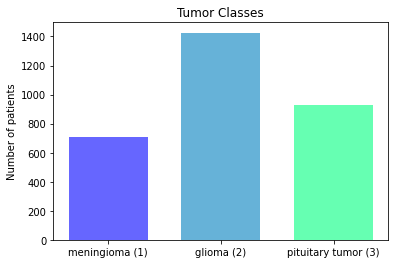

In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

my_cmap = plt.get_cmap("winter")
classes, counts = np.unique(labels, return_counts=True)
rescale = lambda labels: (labels - np.min(labels)) / (np.max(labels) - np.min(labels))
plt.bar(classes, counts, tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'], color = my_cmap(rescale(classes)), width = 0.7, alpha= 0.6)
plt.title('Tumor Classes')
plt.ylabel('Number of patients')

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

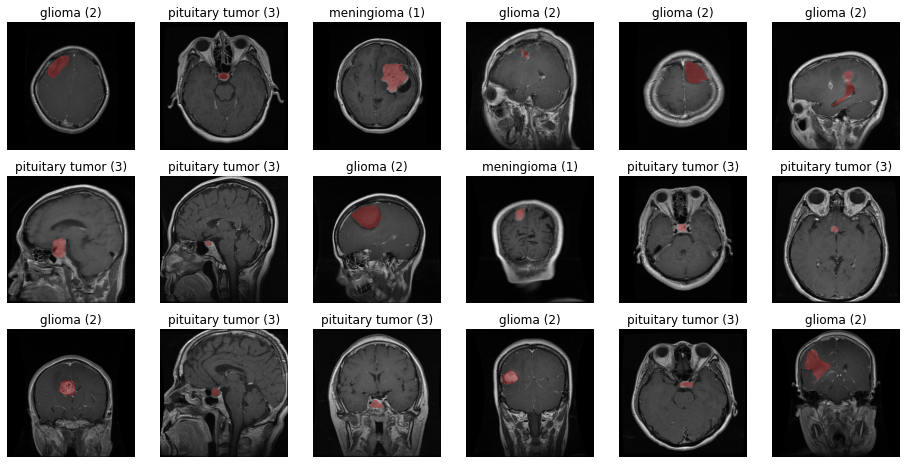

In [ ]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')
    
    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')
    
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

In [ ]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox
    
    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])
    
    return image[y1:y2, x1:x2]

In [ ]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pourcentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))
        
    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)
    
clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

(3064, 224, 224)


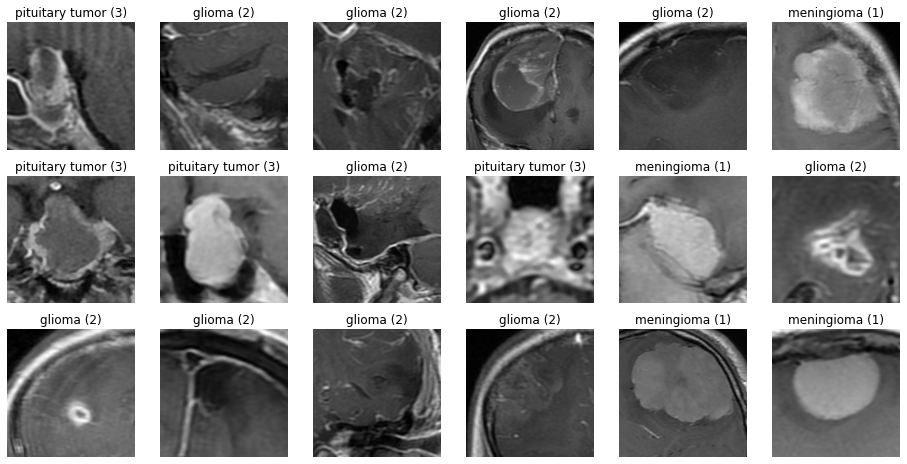

In [ ]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

In [ ]:
X_images = images_cropped.reshape(images_cropped.shape[0], -1)

In [ ]:
import multiprocessing

#Torch libs
import torch

#Plot libs
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

#io libs
import pandas as pd
import numpy as np
import scipy.io as sio

#System libs
import os
import sys

#Classifier
from xgboost import XGBClassifier

#Sklearn libs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def cmap(y_test, y_pred):
    ''' It calculates and plot the confusion matrix.
        Confusion Matrix: describe the performance of a classfication model on a set of test data'''

    #Calculation of the confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    class_names = [1,2,3]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))

    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    #Create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu", fmt = 'g')
    ax.xaxis.set_label_position('top')

    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.show()

    return 

In [ ]:
def func_metrics(y_test, y_pred): 
  '''Calculates the performance of the model using specific metrics'''

  x=PrettyTable()
  
  x.add_column("Accuracy ", [metrics.accuracy_score(y_test, y_pred)])
  x.add_column("Precision ", [metrics.precision_score(y_test, y_pred, average='micro')])
  x.add_column("Recall ", [metrics.recall_score(y_test, y_pred, average='micro')])
  x.add_column("F1 ", [metrics.f1_score(y_test, y_pred, average='micro')])

  return x

In [ ]:
def K_Fold(X, y, n_splits): 

  # model_sk = XGBClassifier(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
  #                     colsample_bynode = 1, colsample_bytree = 1, gamma = 0,
  #                     learning_rate = 0.1, max_delta_step = 0, max_depth = 4,
  #                     min_child_weight = 1, missing = None, n_estimators = 100, n_jobs = 1,
  #                     nthread = None, objective = 'gpu:multi:softmax', random_state = 0,
  #                     reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, seed = None,
  #                     silent = None, subsample = 0.7, verbosity = 1)
  
  model_svm = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                  probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                  max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

  # create stratified kfold object split
  skf = StratifiedKFold(n_splits=n_splits)

  for train_ind, test_ind in skf.split(X,y):
        
      corr_train_inter = X[train_ind]
      corr_test = X[test_ind] 
      Y_train_inter = y[train_ind]
      Y_test = y[test_ind]
      
      model_sk.fit(corr_train_inter,Y_train_inter)
      y_hat = model_sk.predict(corr_test)

  scores = cross_val_score(model_sk, corr_train_inter, Y_train_inter, cv=n_splits) #Accuracy of each K-fold
  scores_mean = scores.mean()
  st_scores = scores.std()*2 

  return scores, scores_mean, st_scores

In [ ]:
def performance(model, X_test, y_test, X_train, y_train, y_pred, k_fold= False): 
  '''Postcondition: mets: metrics, AUCROC, CMAP, Kfold '''
  

  mets=func_metrics(y_test, y_pred)
  print(mets)
  print('\n')

  train_yhat = model.predict(X_train)
  mets_training = func_metrics(y_train, train_yhat)
  print('Training: ', mets_training)

  if k_fold: 
    scores, mean, std = K_Fold(images_cropped.reshape(images_cropped.shape[0], -1), labels, n_splits=5)
    z=PrettyTable()
    z.add_column("Scores ", [scores])
    z.add_column("Mean Accuracy",[mean])
    print(z)
    #print("Scores: ", scores) 
    #print("Accuracy1: %0.2f (+/-%0.2f)" %(mean, std)) #Accuracy of the complete model

  # AUCROC(model, X_test, y_test, X_train, y_train)
  print('\n')
  cmap(y_test, y_hat)

  return 

In [ ]:
#Split
seed=45
X_train, X_test, y_train, y_test = train_test_split(images_cropped.reshape(images_cropped.shape[0], -1), labels, test_size = 0.2, random_state = seed)


#Model generation
model= SVC(C=100, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                  probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                  max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

#Training
print(X_train.shape)
print(y_train.shape)
model.fit(X_train, y_train)

#Testing
y_hat = model.predict(X_test)

(2451, 50176)
(2451,)


In [ ]:
y_hat

array([1, 2, 1, 2, 3, 3, 1, 3, 2, 1, 1, 2, 3, 1, 2, 2, 3, 3, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 3, 3, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2,
       3, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 1, 2, 2, 1, 3, 1, 2,
       2, 3, 2, 2, 2, 2, 1, 1, 2, 3, 3, 3, 2, 2, 3, 3, 2, 1, 1, 3, 2, 2,
       1, 3, 3, 2, 2, 1, 2, 1, 3, 3, 2, 3, 2, 1, 2, 3, 3, 1, 3, 2, 1, 2,
       2, 1, 1, 2, 3, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3,
       2, 3, 2, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 2,
       3, 2, 1, 3, 2, 2, 2, 2, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2,
       1, 1, 3, 2, 3, 3, 3, 3, 3, 1, 3, 2, 1, 3, 1, 1, 2, 2, 3, 2, 2, 2,
       1, 1, 2, 3, 3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3,
       1, 3, 2, 2, 2, 2, 3, 1, 1, 2, 1, 2, 1, 2, 2, 3, 1, 3, 2, 2, 2, 2,
       1, 1, 3, 2, 1, 2, 2, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 2, 2, 3, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 3, 2, 3, 3, 3, 3, 1, 2, 3,
       1, 3, 2, 2, 3, 2, 1, 3, 3, 2, 1, 2, 2, 3, 2,

+--------------------+--------------------+--------------------+--------------------+
|     Accuracy       |     Precision      |      Recall        |        F1          |
+--------------------+--------------------+--------------------+--------------------+
| 0.8384991843393148 | 0.8384991843393148 | 0.8384991843393148 | 0.8384991843393148 |
+--------------------+--------------------+--------------------+--------------------+


Training:  +--------------------+--------------------+--------------------+--------------------+
|     Accuracy       |     Precision      |      Recall        |        F1          |
+--------------------+--------------------+--------------------+--------------------+
| 0.9967360261117911 | 0.9967360261117911 | 0.9967360261117911 | 0.9967360261117911 |
+--------------------+--------------------+--------------------+--------------------+




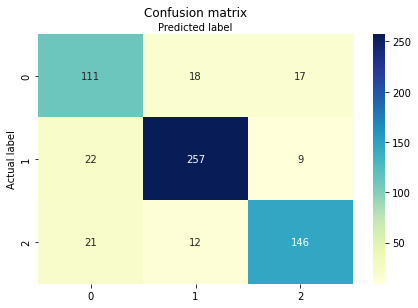

In [ ]:
performance(model, X_test, y_test, X_train, y_train, y_hat, k_fold = False)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 3)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="test score")

    plt.legend(loc="best")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


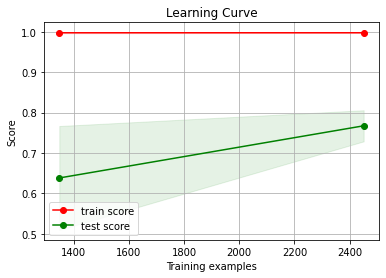

In [ ]:
plot_learning_curve(model,'Learning Curve',X_images, labels)

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001, 'scale', 'auto'],
              'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, return_train_score = True)
grid.fit(X_train,y_train)

# Results
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 7.2min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.6min remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 7.2min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 7.2min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 7.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 7.0min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total= 2.2min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total= 2.2min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total= 2.1min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

In [ ]:
#Hyperparameters to tune
             }
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

# grid search with cross validation


grid = GridSearchCV(
        estimator  = SVC()
        param_grid = param_grid,
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Results
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

# **Unsupervised Learning**

In [ ]:
kmeans = KMeans(n_clusters=3).fit(X_images[:300])
centroids = kmeans.cluster_centers_
print(centroids)

[[1099.73333333 1108.72       1118.84       ... 1213.93333333
  1209.16       1201.8       ]
 [ 278.15517241  277.36206897  276.5        ...  273.70689655
   273.56896552  273.55172414]
 [ 708.11976048  706.17964072  703.86826347 ...  799.19161677
   800.89221557  802.89221557]]


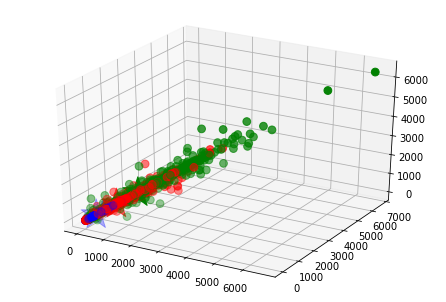

In [ ]:
# Predicting the clusters
labels_kmeans = kmeans.predict(X_images)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels_kmeans:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_images[:, 0], X_images[:, 1], X_images[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

In [ ]:
def plot_cluster_predictions(clustering, X, n_clusters = None, cmap = plt.cm.plasma,
                             plot_data=True, plot_centers=True, show_metric=False,
                             title_str=""):

    assert not hasattr(clustering, "n_clusters") or \
           (hasattr(clustering, "n_clusters") and n_clusters is not None), "must specify `n_clusters` for "+str(clustering)

    if n_clusters is not None:
        clustering.n_clusters = n_clusters

    y = clustering.fit_predict(X)
    # remove elements tagged as noise (cluster nb<0)
    X = X[y>=0]
    y = y[y>=0]

    if n_clusters is None:
        n_clusters = len(np.unique(y))

    if plot_data:        
        plt.scatter(X[:,0], X[:,1], color=cmap((y*255./(n_clusters-1)).astype(int)), alpha=.5)
    if plot_centers and hasattr(clustering, "cluster_centers_"):
        plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=150,  lw=3,
                    facecolor=cmap((np.arange(n_clusters)*255./(n_clusters-1)).astype(int)),
                    edgecolor="black")   

    if show_metric:
        sc = silhouette_score(X, y) if len(np.unique(y))>1 else 0
        plt.title("n_clusters %d, sc=%.3f"%(n_clusters, sc)+title_str)
    else:
        plt.title("n_clusters %d"%n_clusters+title_str)

    plt.axis("off")
    return

In [ ]:
def experiment_number_of_clusters(X, clustering, show_metric=True,
                                  plot_data=True, plot_centers=True, plot_boundaries=False):
    plt.figure(figsize=(15,6))
    for n_clusters in pbar()(range(2,10)):
        clustering.n_clusters = n_clusters
        y = clustering.fit_predict(X)

        cm = plt.cm.plasma
        plt.subplot(2,4,n_clusters-1)

        plot_cluster_predictions(clustering, X, n_clusters, cm, 
                                 plot_data, plot_centers, show_metric)

In [ ]:
def pbar(**kwargs):
    sys.stdout.flush()
    sys.stderr.flush()
    time.sleep(.2)
    return progressbar.ProgressBar(**kwargs)

100% (8 of 8) |##########################| Elapsed Time: 0:36:16 Time:  0:36:16


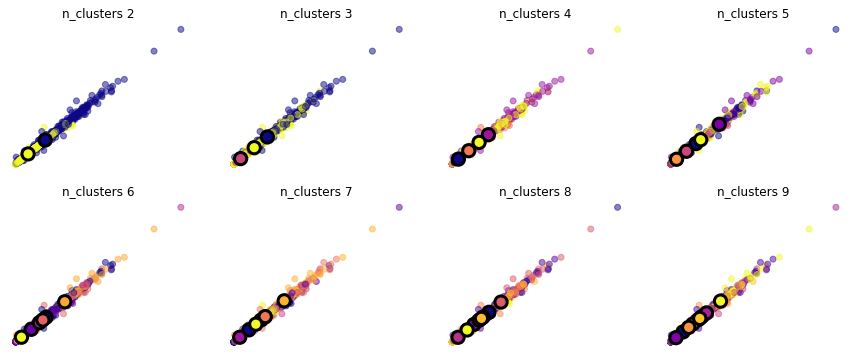

In [ ]:
experiment_number_of_clusters(X_images, KMeans(), show_metric=False)

In [ ]:
def silhouette_analysis(X):
    range_n_clusters = [2, 3, 4, 5, 6]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(19, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        # clusterer = SpectralClustering(n_clusters=n_clusters)
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for %s clustering on sample data "
                      "with n_clusters = %d, score = %.3f" % (clusterer.__class__.__name__, n_clusters,silhouette_avg)),
                     fontsize=14, fontweight='bold')

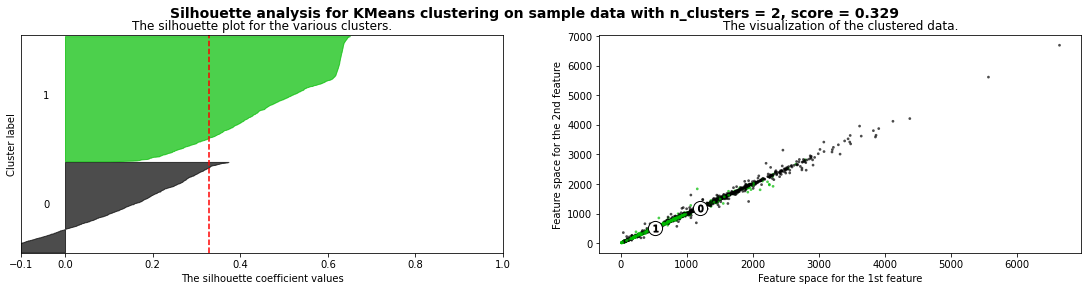

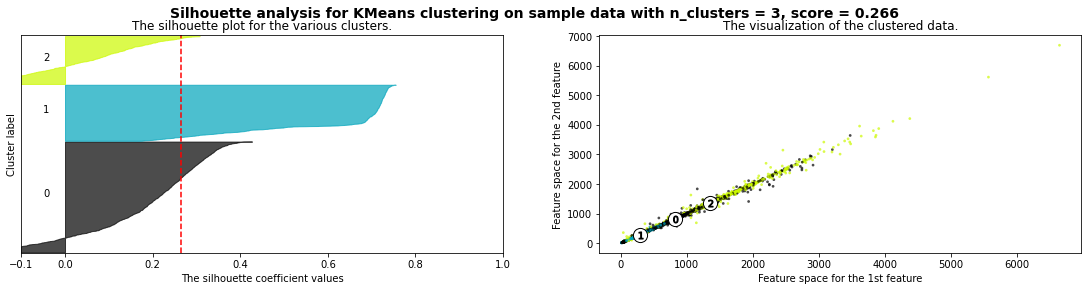

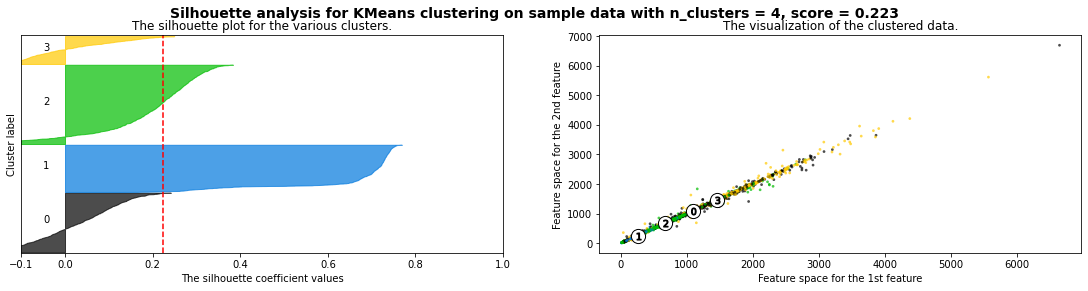

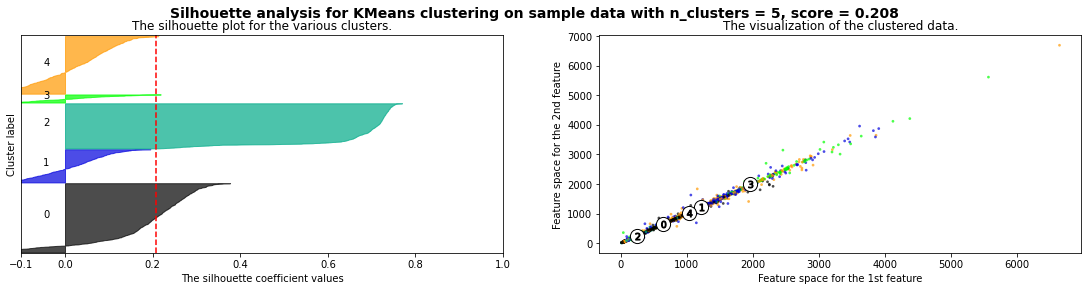

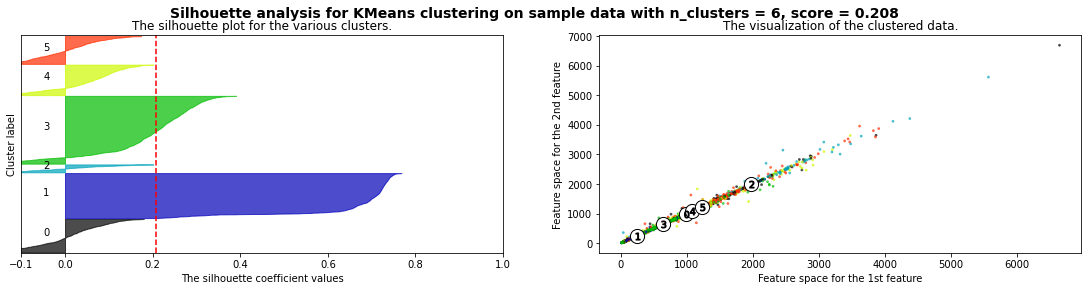

In [ ]:
silhouette_analysis(X_images)

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph
knn_graph = kneighbors_graph(X_images, 20, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")

In [ ]:
plot_cluster_predictions(ac, X_images, n_clusters=3, cmap=plt.cm.plasma)

In [ ]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=3).fit_predict(X_images)
print(np.unique(sc))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


[0 1 2]


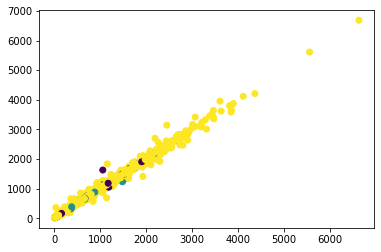

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X_images[:,0], X_images[:,1], c=sc)
plt.show() 
fig = plt.figure()

N/A% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
 12% (1 of 8) |###                       | Elapsed Time: 0:00:33 ETA:   0:03:54/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected

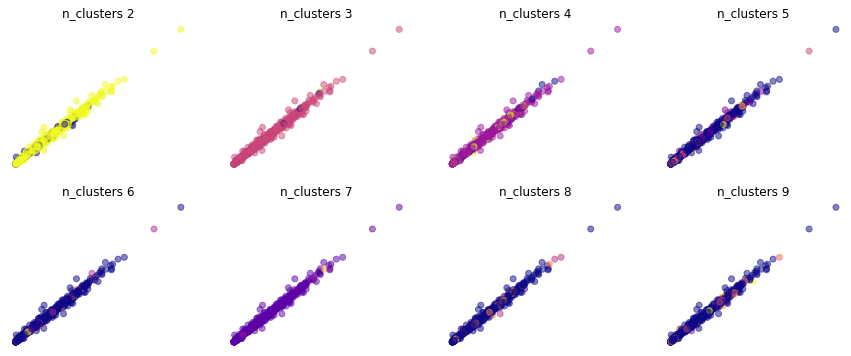

In [ ]:
experiment_number_of_clusters(X_images, SpectralClustering(), show_metric=False)